In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split

In [2]:
#Load the data needed
aggXGB = pd.read_parquet('Data/agg_table_new_zones8Bot.parquet')
pivot_df = aggXGB.pivot(index='time_bin', columns='h3_index', values='order_count').fillna(0) #Pivoting for all zones
adj_matrix = pd.read_parquet('Data/neighbours_zones_8.parquet') #Load adjacency matrix
adj_matrix.index = adj_matrix.columns

In [3]:
#Prepare data
adj_matrix.index = adj_matrix.index.astype(str)
adj_matrix.columns = adj_matrix.columns.astype(str)
original_area_columns = pivot_df.columns.tolist()

In [4]:
#Combine matrix with pivot
common_indices = list(set(original_area_columns) & set(adj_matrix.index) & set(adj_matrix.columns))
neighbor_df = adj_matrix.loc[common_indices, common_indices]


# Create a dictionary map based on neighbours
h3_indices_in_pivot = original_area_columns # Use the order
neighbor_map = {h3_index: [] for h3_index in h3_indices_in_pivot}

neighbor_df_indices = neighbor_df.index.tolist()

# Walk through of each area
for center_h3 in h3_indices_in_pivot:
    if center_h3 in neighbor_df_indices:
        # Find neighbours
        neighbors = neighbor_df.columns[neighbor_df.loc[center_h3] == 1].tolist()
        # Add neighbours 
        valid_neighbors = [nb for nb in neighbors if nb in h3_indices_in_pivot and nb != center_h3]
        neighbor_map[center_h3] = valid_neighbors


# Cumulate the orders of neighbours
pivot_df_with_neighbors = pivot_df.copy()
neighbor_sum_cols = []

for h3_index in original_area_columns:
    neighbor_feature_name = f'{h3_index}_neighbor_sum'
    neighbor_sum_cols.append(neighbor_feature_name)
    # Use neighbours of first mapping
    valid_neighbors = [neighbor for neighbor in neighbor_map.get(h3_index, []) if neighbor in pivot_df.columns]

    if valid_neighbors:
        pivot_df_with_neighbors[neighbor_feature_name] = pivot_df[valid_neighbors].sum(axis=1)
    else:
        pivot_df_with_neighbors[neighbor_feature_name] = 0.0


pivot_df = pivot_df_with_neighbors #The new data frame for going further


C:\Users\freud\AppData\Local\Temp\ipykernel_16616\1294115367.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot_df_with_neighbors[neighbor_feature_name] = pivot_df[valid_neighbors].sum(axis=1)
C:\Users\freud\AppData\Local\Temp\ipykernel_16616\1294115367.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot_df_with_neighbors[neighbor_feature_name] = pivot_df[valid_neighbors].sum(axis=1)
C:\Users\freud\AppData\Local\Temp\ipykernel_16616\1294115367.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usu

In [5]:
#Preparing features
pivot_df = pivot_df.reset_index()
pivot_df['hour'] = pivot_df['time_bin'].dt.hour #get hour
pivot_df['dayofweek'] = pivot_df['time_bin'].dt.dayofweek #get day of week
pivot_df['hour_sin'] = np.sin(2 * np.pi * pivot_df['hour'] / 24) #sin and cos better as cyclian feature
pivot_df['hour_cos'] = np.cos(2 * np.pi * pivot_df['hour'] / 24)
pivot_df['day_sin'] = np.sin(2 * np.pi * pivot_df['dayofweek'] / 7)
pivot_df['day_cos'] = np.cos(2 * np.pi * pivot_df['dayofweek'] / 7)
pivot_df['is_weekend'] = pivot_df['dayofweek'].isin([5, 6]).astype(int) #get weekend feature
time_bins_original = pivot_df['time_bin'].copy() #copy for exporting file


In [6]:
pivot_df_for_model = pivot_df.drop(columns=['time_bin', 'hour', 'dayofweek']) #don't need anymore as feature

In [7]:
# List of feature columns
time_feature_cols = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'is_weekend']
area_columns = original_area_columns
ordered_cols = area_columns + neighbor_sum_cols + time_feature_cols
missing_cols = [col for col in ordered_cols if col not in pivot_df_for_model.columns]

pivot_df_for_model = pivot_df_for_model[ordered_cols]

# change to a numpy array
data = pivot_df_for_model.values

In [8]:
# Create xgb function with 4 timesteps as window
def create_xgb_dataset(data, time_steps=4, n_target_features=None, n_neighbor_features=None, n_time_features=None):
    X, y = [], []
    target_end_idx = n_target_features
    neighbor_end_idx = n_target_features + n_neighbor_features
    time_start_idx = neighbor_end_idx

    for i in range(len(data) - time_steps):
        lagged_targets_part = data[i : i + time_steps, :target_end_idx].flatten()
        lagged_neighbors_part = data[i : i + time_steps, target_end_idx : neighbor_end_idx].flatten()
        current_time_features = data[i + time_steps, time_start_idx :]
        X.append(np.concatenate([lagged_targets_part, lagged_neighbors_part, current_time_features]))
        y.append(data[i + time_steps, :target_end_idx])

    X = np.array(X)
    y = np.array(y)
    return X, y

In [9]:
time_steps = 4
n_areas = len(area_columns)
n_target_features = n_areas
n_neighbor_features = len(neighbor_sum_cols) # Number of features
n_time_features = len(time_feature_cols)

#Run the xgb function with 4 time steps and time and neighbour features
X, y = create_xgb_dataset(data,
                            time_steps=time_steps,
                            n_target_features=n_target_features,
                            n_neighbor_features=n_neighbor_features,
                            n_time_features=n_time_features)

print('Teile Daten auf (Train/Val/Test)...')
# Split to test and validation set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.125, shuffle=False # last day
)

# Aufteilung von Training+Validierung in Training und Validierung
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.15, shuffle=False # roughly the day prior last day
)

print(f'Train shapes: X={X_train.shape}, y={y_train.shape}')
print(f'Val shapes:   X={X_val.shape}, y={y_val.shape}')
print(f'Test shapes:  X={X_test.shape}, y={y_test.shape}')

Teile Daten auf (Train/Val/Test)...
Train shapes: X=(567, 1117), y=(567, 139)
Val shapes:   X=(101, 1117), y=(101, 139)
Test shapes:  X=(96, 1117), y=(96, 139)


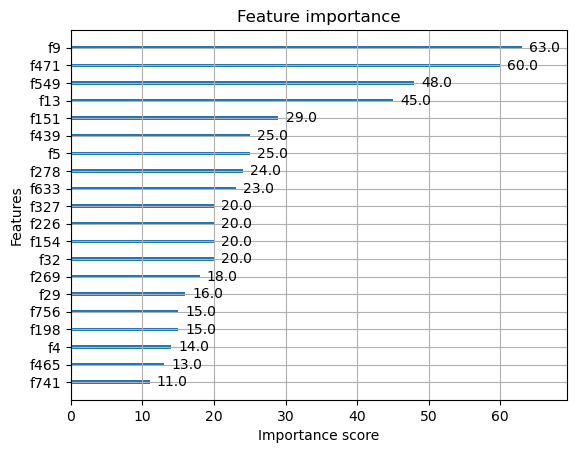

In [11]:
# Train the model
models = []
predictions = np.zeros_like(y_test)
for i in range(y.shape[1]):  # For each zone
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        verbosity=0,
        random_state=42,
        early_stopping_rounds=50 # Early Stopping activated
    )
    model.fit(
        X_train, y_train[:, i],
        eval_set=[(X_val, y_val[:, i])], # Validationset for early stopping
        verbose=False # To not get output each round
    )
    pred = model.predict(X_test)
    predictions[:, i] = pred
    models.append(model)

# Check feature importance for example model
feature_names = [f'lag_target_{t}_{a}' for t in range(time_steps) for a in area_columns] + \
                [f'lag_neighbor_{t}_{a}' for t in range(time_steps) for a in area_columns] + \
                time_feature_cols
xgb.plot_importance(models[0], max_num_features=20) # Importance for first model
plt.show()

In [18]:
''' 
Evaluation of performance metrics 
'''

#Combine results of all zones
y_tests_all = y_test.flatten()
y_preds_all = predictions.flatten()

n = len(y_tests_all) #Number of predictions
p = X_train.shape[1] #Number of features

rmse = np.sqrt(mean_squared_error(y_tests_all, y_preds_all))
mae = mean_absolute_error(y_tests_all, y_preds_all)
r2 = r2_score(y_tests_all, y_preds_all)

mean_abs_actual = np.mean(np.abs(y_tests_all))
if mean_abs_actual == 0:
    nrmse = np.nan # Avoid division by zero value
else:
    nrmse = rmse / mean_abs_actual * 100

nonzero_indices = y_tests_all != 0
if np.any(nonzero_indices):
    mape = np.mean(np.abs((y_tests_all[nonzero_indices] - y_preds_all[nonzero_indices]) / y_tests_all[nonzero_indices])) * 100
else:
    mape = np.nan

# Adjusted R² Calculation
if n - p - 1 == 0:
    adj_r2 = np.nan # Avoid division by zero
else:
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)


print(f'MAPE: {mape:.2f}%')
print(f'NRMSE: {nrmse:.2f}%')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R²: {r2:.2f}')
print(f'Adjusted R²: {adj_r2:.2f}')

MAPE: 47.31%
NRMSE: 58.78%
RMSE: 2.71
MAE: 1.30
R²: 0.94
Adjusted R²: 0.94


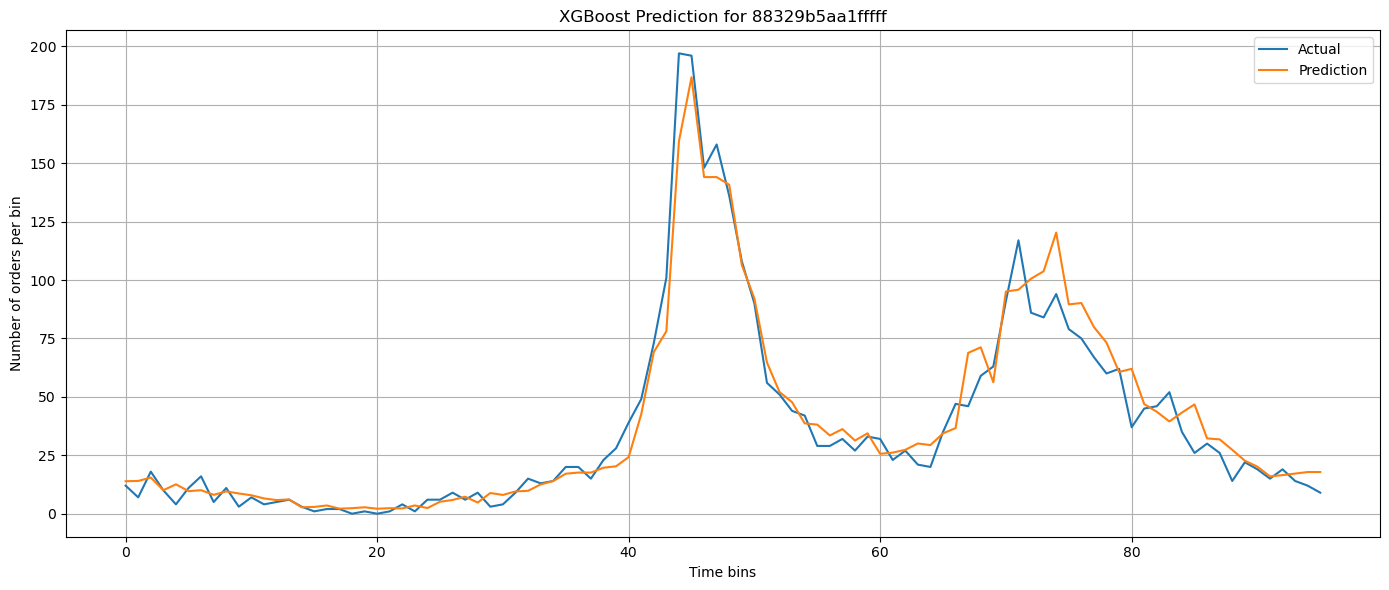

In [19]:
example_area = '88329b5aa1fffff'  # Our area to compare

example_index = original_area_columns.index(example_area)

plt.figure(figsize=(14, 6))
plt.plot(y_test[:, example_index], label='Actual')
plt.plot(predictions[:, example_index], label='Prediction')
plt.title(f'XGBoost Prediction for {example_area}')
plt.xlabel('Time bins')
plt.ylabel('Number of orders per bin')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
example_area = '88329b5aa1fffff'  # change the area to observe
example_index = original_area_columns.index(example_area)
#np.save('prognose_XGB.npy', predictions[:, example_index])


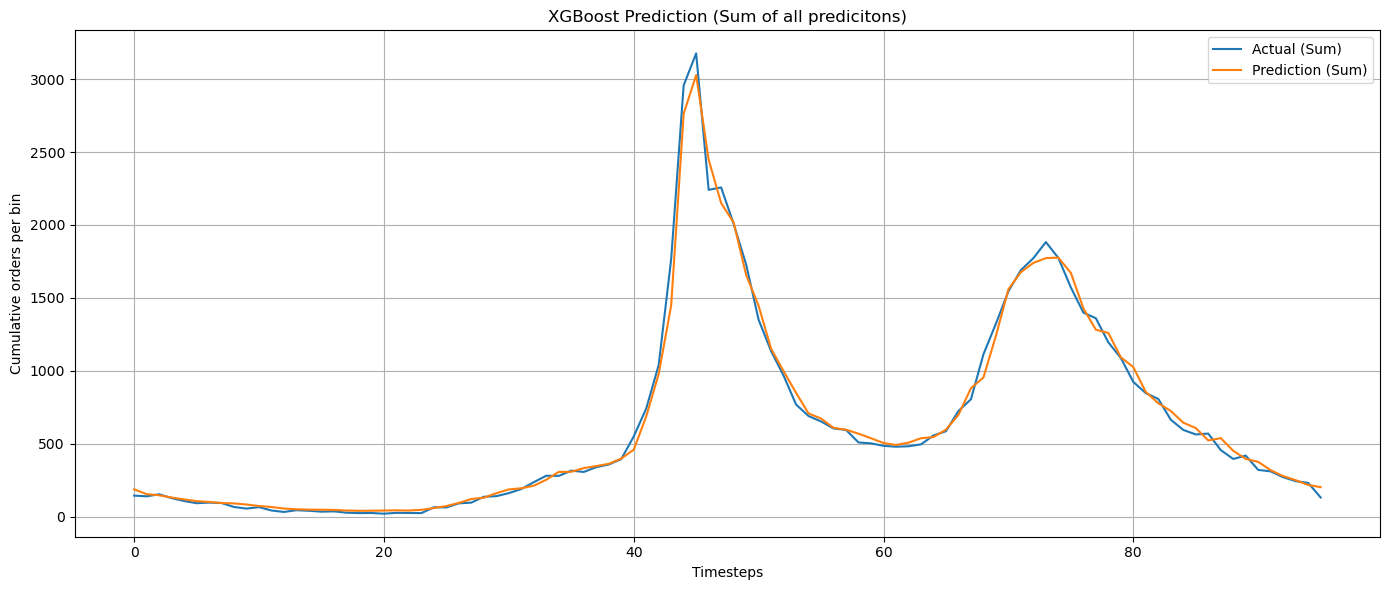

In [21]:
total_actual_per_step = np.sum(y_test, axis=1)
total_predicted_per_step = np.sum(predictions, axis=1)

plt.figure(figsize=(14, 6))
plt.plot(total_actual_per_step, label='Actual (Sum)')
plt.plot(total_predicted_per_step, label='Prediction (Sum)')
plt.title('XGBoost Prediction (Sum of all predicitons)')
plt.xlabel('Timesteps')
plt.ylabel('Cumulative orders per bin')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
'''
Here calculation of all features (like we would have split the zones only for prediction performance and merge later)
'''
rmse_total = np.sqrt(mean_squared_error(total_actual_per_step, total_predicted_per_step))
mae_total = mean_absolute_error(total_actual_per_step, total_predicted_per_step)
r2_total = r2_score(total_actual_per_step, total_predicted_per_step)
mask_total = total_actual_per_step != 0
if np.any(mask_total):
    mape_total = np.mean(np.abs((total_actual_per_step[mask_total] - total_predicted_per_step[mask_total]) / total_actual_per_step[mask_total])) * 100
else:
    mape_total = np.nan

print(f'RMSE (Sum): {rmse_total:.2f}')
print(f'MAE  (Sum): {mae_total:.2f}')
print(f'R²   (Sum): {r2_total:.2f}')
print(f'MAPE (Sum): {mape_total:.2f}%')

RMSE (Sum): 63.39
MAE  (Sum): 39.52
R²   (Sum): 0.99
MAPE (Sum): 14.45%


In [24]:
''' 
The parquet we use as predicted demand for our repositioning
'''

test_start_original_index = len(X_train) + len(X_val) + time_steps

if test_start_original_index < len(time_bins_original):
    test_timestamps = time_bins_original.iloc[test_start_original_index:].reset_index(drop=True)

    # DataFrame with predictions
    predictions_df_wide = pd.DataFrame(predictions, columns=area_columns)
    predictions_df_wide['time_bin'] = test_timestamps

    # convert to (long format)
    predictions_df_long = pd.melt(
        predictions_df_wide,
        id_vars=['time_bin'],
        var_name='hex_id', # Name of H3 index column
        value_name='predicted_order_count' 
    )

    predictions_df_long['predicted_order_count'] = predictions_df_long['predicted_order_count'].round().astype(int)
    predictions_df_long['predicted_order_count'] = predictions_df_long['predicted_order_count'].clip(lower=0)
    predictions_df_long['time_bin'] = pd.to_datetime(predictions_df_long['time_bin'])

    start_time_str = '2022-10-24 14:00:00'
    end_time_str = '2022-10-24 17:00:00'
    start_time = pd.to_datetime(start_time_str)
    end_time = pd.to_datetime(end_time_str)

    filtered_predictions_df = predictions_df_long[
        (predictions_df_long['time_bin'] >= start_time) &
        (predictions_df_long['time_bin'] <= end_time)
    ].copy() # .copy() for an indipendent cooy

    output_path_filtered = 'predicted_values.parquet'
    filtered_predictions_df.to_parquet(output_path_filtered)